In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc
import random
import warnings

from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, log_loss, roc_curve, auc, accuracy_score, precision_score, recall_score,confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error

import os
import sys
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
import optuna
from optuna import Trial


# ## Set python parameters
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
np.random.seed(2018)

gcol = 'real_rce'


#Here for posterity
def sig(x,L=1,k=1,xo=0): #general form of logistic regression
    return L/(1 + np.e**(-k*(x-xo)))

def syndrop(x): #adds noise to synthetic drop data based on rate
    #at high x, sig approaches 1, highly likely to return a drop
    if np.random.rand() >= sig(x,k=17,xo=.17):
        return 0
    else:
        return 1  
    

#read in datasets
train = pd.read_csv("../preprocessing/output_data/train_X.csv")
train_y = pd.read_csv("../preprocessing/output_data/train_y.csv")
train_real_values = train_y[train_y.columns[0]].values
del train_y

test = pd.read_csv("../preprocessing/output_data/test_X.csv")
test_y = pd.read_csv("../preprocessing/output_data/test_y.csv")
test_real_values = test_y[test_y.columns[0]].values
del test_y

cats = np.load("../../input_data/historical/new_remapped_labels_2020_10_27.npy",allow_pickle=True).item()
catsi = [list(test.columns).index(i) for i in cats]

def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    y_valid_pred_total = np.zeros(train.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(train,train_real_values):
        train_data = train.iloc[train_idx,:], train_real_values[train_idx]
        valid_data = train.iloc[valid_idx,:], train_real_values[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data, cat_features=cats,seed=seed,
                                            num_rounds=3000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

# Referred https://github.com/pfnet/optuna/blob/master/examples/lightgbm_simple.py

def fit_lgbm(trial, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=3000):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 600),
        'objective': 'regression',
        'max_depth': trial.suggest_int('max_depth',6,12),
        'learning_rate': trial.suggest_loguniform('learning_rate',1e-3,1e-1),
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        "metric": metric, "num_threads": 8,
        #'max_bin':63, 
        #'gpu_use_dp': False,
        "verbosity": -1, 
        'device': 'cpu', 
        #'gpu_device_id': 1
    }
    
    params['seed'] = seed

    early_stop = 500
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'l2', valid_name='valid_1')    

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [2]:
def o2(p2, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    y_valid_pred_total = np.zeros(train.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(train,train_real_values):
        train_data = train.iloc[train_idx,:], train_real_values[train_idx]
        valid_data = train.iloc[valid_idx,:], train_real_values[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit2(p2, train_data, valid_data, cat_features=cats,seed=seed,
                                            num_rounds=3000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, train_real_values
    else:
        return valid_score

In [3]:
def fit2(p2, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=3000):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'objective': 'regression',
        "boosting": "gbdt",
        "bagging_freq": 5,
        "metric": metric, 
        "verbosity": -1, 
        'device': 'cpu', "num_threads": 8
    }
    
    params['seed'] = seed

    early_stop = 500
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train({**params,**p2},
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [4]:
runs = pd.read_csv("trial_output.csv")
runs = runs[runs.columns[:13]]
runs = runs.rename(columns=runs.loc[0].dropna().to_dict())
runs = runs.drop(0)
runs = runs.drop('Unnamed: 0',1)
runs = runs[runs.value.notnull()]
runs = runs.sort_values('value')
print(runs.shape)
brun = runs.iloc[0]
brun

(151, 12)


number                                      146
state                       TrialState.COMPLETE
value                                  0.690165
datetime_start       2020-01-10 12:36:36.428018
datetime_complete    2020-01-10 12:47:09.356144
bagging_fraction             0.8609940723727999
feature_fraction            0.44434321717417175
lambda_l1                     6.814280032983452
lambda_l2                     5.584740557535633
learning_rate               0.01554912890585883
max_depth                                    12
num_leaves                                  548
Name: 147, dtype: object

In [5]:
def fixlight(x):
    for i in ['number','state','value','datetime_start','datetime_complete']:
        del x[i]
    x = x.astype(float).to_dict()
    for i in ['max_depth','num_leaves']:
        x[i] = int(x[i])
    return x

b2 = fixlight(brun)

In [6]:
np.save('lightparam1.npy',b2)

In [7]:
oout = o2(brun, fast_check=False,return_info=True)

train 77624 valid 19407
training LGB:


/home/brandon/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[500]	training's l2: 0.526133	valid_1's l2: 0.690917
[1000]	training's l2: 0.436067	valid_1's l2: 0.691502
Early stopping, best iteration is:
[691]	training's l2: 0.487689	valid_1's l2: 0.690165
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.48768864443448984)]), 'valid_1': OrderedDict([('l2', 0.6901650835562042)])})
train 77625 valid 19406
training LGB:
Training until validation scores don't improve for 500 rounds
[500]	training's l2: 0.526864	valid_1's l2: 0.70461
[1000]	training's l2: 0.438413	valid_1's l2: 0.70424
Early stopping, best iteration is:
[738]	training's l2: 0.479941	valid_1's l2: 0.703108
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.47994050235180247)]), 'valid_1': OrderedDict([('l2', 0.7031080890044796)])})
train 77625 valid 19406
training LGB:
Training until validation scores don't improve for 500 rounds
[500]	trai

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
vals = np.zeros(test.shape[0])
for i in oout[1]:
    vals += i.predict(test)
vals = vals / len(oout[1])

In [10]:
bs = np.load("../preprocessing/scale_rce.npy",allow_pickle=True).item()
v2 = (vals * bs['std']) + bs['mean'] 
t2 = (test_real_values * bs['std']) + bs['mean']

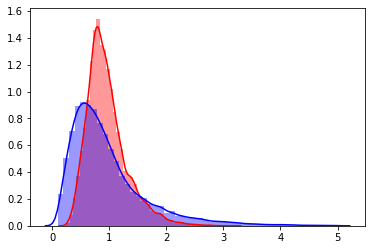

In [11]:
sns.distplot(v2,color='r',label='pred')
sns.distplot(t2,color='b',label='act')
plt.show()

Text(0, 0.5, 'actual rce')

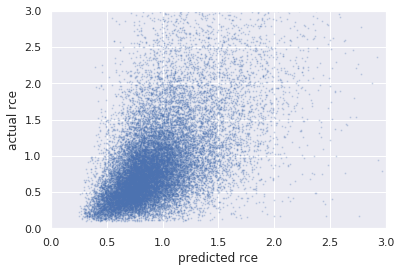

In [12]:
sns.set(style='darkgrid')
plt.scatter(v2,t2,alpha=0.2,s=1)
plt.xlim([0,3])
plt.ylim([0,3])
plt.xlabel("predicted rce")
plt.ylabel("actual rce")

In [13]:
mean_squared_error(t2,v2)

0.32085697174787325

In [14]:
np.save("light_rce_models.npy",oout[1])

In [15]:
fs = []
for i in oout[1]:
    feature_imp = pd.DataFrame(sorted(zip(i.feature_importance(),train.columns)), columns=['Value','Feature']).sort_values('Value',ascending=False).set_index("Feature")
    fs.append(feature_imp)

In [16]:
fsc = pd.concat(fs,axis=1)
fsc['avv'] = fsc.mean(axis=1)
pd.set_option('max_rows',1000)
fsc.sort_values('avv')

Value  Value  Value  Value  Value      avv
FuelDescription                    649    700    614    549    617    625.8
EducationLevel                    1133   1437   1227    959   1196   1190.4
HHSIZE                            1844   1984   1788   1438   1751   1761.0
DwellingType                      1817   1867   1719   1627   1838   1773.6
state                             2301   2755   2417   1926   2434   2366.6
Marital Status                    2426   2707   2299   2127   2415   2394.8
Mail Public Responder Indicator   2885   3031   2780   2382   2713   2758.2
OccupationRollup                  3038   3295   2988   2575   2988   2976.8
Home Ownership                    3770   3925   3700   3315   3587   3659.4
Gender                            4385   4741   4086   3699   4100   4202.2
NetworthIndicator_Rollup          4551   4679   4372   3738   4392   4346.4
ESTINCOME                         5229   5354   4799   4144   5111   4927.4
SALE_PRICE                       13628  14179  12819  11376  13297  13059.8
ASSD_TOTAL_VALUE                 15320  15896  14724  12773  15070  14756.6
UNIVERSAL_BUILDING_SQUARE_FEET   15412  16463  14799  12770  15001  14889.0
YEAR_BUILT                       18407  19335  17333  14965  17667  17541.4
AGEOFINDIVIDUAL                  18715  20233  18425  15295  18467  18227.0
LAND_SQUARE_FOOTAGE_D            19687  20750  18227  16771  18792  18845.4
ASSD_LAND_VALUE                  20391  21897  20073  18093  20473  20185.4
median_home_value                21093  22587  20221  17071  20590  20312.4
median_income                    21894  22343  20527  17817  20533  20622.8
latitude                         22231  23319  20901  17818  21716  21197.0
population                       22297  23692  21424  19191  21568  21634.4
Home Value Range                 22932  24027  21451  18853  22388  21930.2
longitude                        24052  25312  22802  19115  23216  22899.4